Using limma for key cluster DEG analysis

In [1]:
library(limma)
library(dplyr)
library(ggplot2)
library(edgeR)
library(stringr)
library(reshape2)
library(ggrepel)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# read the voom normalised data
exp_df <- read.csv('/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/Fresh_FORGE/Data/Exp.csv', header = T, row.names = 1)    
head(exp_df)

,A1BG,A1BG.AS1,A2M,A4GALT,AAAS,AACS,AADAT,AAGAB,AAK1,AAMDC,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
127399,1.33585123,2.837184,-0.4757615,3.522372,5.289224,5.436261,1.912285,6.170977,5.486915,5.2589014,⋯,6.255815,7.125433,0.9700382,3.911810,3.513628,3.6713206,5.387186,7.657886,4.690012,5.671180
143B,0.50502144,1.146315,4.0206406,2.191379,5.726666,3.992820,3.975156,6.908841,4.667542,2.9568233,⋯,7.219736,7.134179,1.4876841,4.076379,4.290047,3.9134273,4.413880,7.452491,5.690861,6.489629
170MGBA,-6.34365096,-1.951334,7.9345323,3.568739,4.676171,4.810112,2.668508,6.323091,6.443912,3.2753462,⋯,5.663259,4.028126,2.9669618,4.290252,4.614660,-7.9286135,6.486930,7.582614,6.399150,7.430827
22RV1,-0.05089222,2.802209,2.9740419,-2.257672,6.130935,6.428204,3.251642,6.020554,6.088325,0.6373114,⋯,6.658125,7.350443,1.1318189,3.456761,4.554439,-1.2478247,5.552063,4.451671,5.854928,5.957179
2313287,-4.77226339,-1.602338,-4.7722634,1.264826,5.211839,4.931832,-4.241749,6.394806,5.462554,2.0450756,⋯,6.162984,6.500690,1.9419821,4.451470,4.655631,-3.8547255,5.514551,5.788176,5.886246,6.400234
253J,0.40139481,1.527828,-2.0953405,3.717680,6.460873,5.066240,-4.808059,7.432302,6.160688,2.4514232,⋯,5.223987,6.001888,3.9187273,4.247525,4.068799,0.6909014,4.730023,7.069439,6.007592,5.257582


Using the optuna results

In [3]:
metadata_df <- read.csv('/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Data/egfr_erlotinib_fullRes_optuna.csv', 
      header = T, row.names = 1)
head(metadata_df)

,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,⋯,scaled_dep,scaled_ic50,pred_dep,pred_ic50,set,cell_line,benefit_score_raw,benefit_score_scaled,Cluster,EGFR_exp
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>
22RV1,15.0705163,2.110318,12.507632,-12.3001276,12.533052,-7.315223,-3.968436,2.595230,-6.3102277,12.1787912,⋯,-0.23383199,1.4116753,0.002935588,0.2929630,test,22RV1,-0.2900274,0.4715281,4,5.194668
2313287,15.1266975,3.992169,-2.582105,-0.5659212,15.970295,-1.398219,6.329730,18.360206,-0.6962557,12.4632126,⋯,0.06971619,0.8030953,0.071632225,-0.6385850,train,2313287,0.7102172,0.5934353,4,6.216027
253J,-25.8416293,5.444899,-13.283011,-8.4338637,4.070306,16.237590,9.521778,-15.382223,13.2863158,-8.8472823,⋯,-0.18586829,-2.5695147,0.112350199,0.4606776,train,253J,-0.3483274,0.4644226,7,8.013383
253JBV,-20.0779146,4.045209,-18.874968,-7.1844085,13.056097,9.383398,-2.857666,-5.584618,9.3234189,-7.0798880,⋯,-0.17223443,-1.3331647,0.160200760,-0.3268950,train,253JBV,0.4870958,0.5662419,7,8.155565
42MGBA,3.4268794,-11.711808,20.527376,-6.8418657,-22.475261,-4.091241,13.658918,-6.201748,21.6172198,-4.0231040,⋯,-0.21166198,1.7827553,-0.227808547,1.7029599,test,42MGBA,-1.9307685,0.2715588,6,7.667959
5637,0.3713208,-11.465137,-8.868652,15.8210674,14.527931,-14.174826,5.578753,9.214807,-9.2509079,-0.9666793,⋯,0.58719471,-4.3995437,0.074773934,-1.5387237,train,5637,1.6134976,0.7035248,25,9.261872


In [4]:
# generate count matrices
exp_df <- t(exp_df)
exp_df <- exp_df[, rownames(metadata_df)]
head(exp_df)

,22RV1,2313287,253J,253JBV,42MGBA,5637,639V,647V,697,769P,⋯,WM88,WM983B,WSUNHL,YAPC,YD15,YD38,YD8,YH13,YKG1,ZR751
A1BG,-0.05089222,-4.772263,0.4013948,-1.5065185,3.4790754,-4.306551,2.7409605,-1.4174997,3.7459340,-4.776628,⋯,2.49406186,2.628940,2.129114,-3.5513311,-1.1348498,-3.621313,-0.404946,2.4096029,2.210062324,3.412477
A1BG.AS1,2.80220906,-1.602338,1.5278280,0.3599799,4.0960204,-2.721589,2.9089948,0.3333603,3.6496159,-2.589001,⋯,3.04251150,2.108998,3.490903,-0.6962794,0.7592815,-3.331806,2.190698,3.6452893,2.674504126,3.356551
A2M,2.97404191,-4.772263,-2.0953405,-1.5359623,-2.4548119,-2.330799,-3.5546809,-1.6168085,-0.7213455,-1.004039,⋯,8.29768498,2.635746,-5.931582,-1.1309993,-1.1903450,-1.063317,2.156859,2.1896872,-0.001606262,-1.284050
A4GALT,-2.25767244,1.264826,3.7176797,4.2817137,0.3433538,4.320618,0.3088171,1.9873214,-4.7131250,2.871230,⋯,-0.02683654,-3.156974,-5.446156,3.6780533,1.2299868,3.754692,4.791033,0.5947922,-0.197701940,2.864265
AAAS,6.13093466,5.211839,6.4608733,6.0833690,5.7955392,5.690910,5.8985897,5.2801031,6.1362801,5.883665,⋯,4.93915757,5.208017,6.107268,4.8938055,5.3573057,5.554445,4.604499,5.1293622,5.275358394,3.899917
AACS,6.42820436,4.931832,5.0662398,5.4715708,5.2133640,5.908011,5.3924960,6.2349405,2.5579135,5.653476,⋯,4.78457221,4.696403,2.842546,5.7034197,5.3439388,4.725940,5.617139,4.5707663,4.750419104,5.277655


In [5]:
head(metadata_df)

,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,⋯,scaled_dep,scaled_ic50,pred_dep,pred_ic50,set,cell_line,benefit_score_raw,benefit_score_scaled,Cluster,EGFR_exp
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>
22RV1,15.0705163,2.110318,12.507632,-12.3001276,12.533052,-7.315223,-3.968436,2.595230,-6.3102277,12.1787912,⋯,-0.23383199,1.4116753,0.002935588,0.2929630,test,22RV1,-0.2900274,0.4715281,4,5.194668
2313287,15.1266975,3.992169,-2.582105,-0.5659212,15.970295,-1.398219,6.329730,18.360206,-0.6962557,12.4632126,⋯,0.06971619,0.8030953,0.071632225,-0.6385850,train,2313287,0.7102172,0.5934353,4,6.216027
253J,-25.8416293,5.444899,-13.283011,-8.4338637,4.070306,16.237590,9.521778,-15.382223,13.2863158,-8.8472823,⋯,-0.18586829,-2.5695147,0.112350199,0.4606776,train,253J,-0.3483274,0.4644226,7,8.013383
253JBV,-20.0779146,4.045209,-18.874968,-7.1844085,13.056097,9.383398,-2.857666,-5.584618,9.3234189,-7.0798880,⋯,-0.17223443,-1.3331647,0.160200760,-0.3268950,train,253JBV,0.4870958,0.5662419,7,8.155565
42MGBA,3.4268794,-11.711808,20.527376,-6.8418657,-22.475261,-4.091241,13.658918,-6.201748,21.6172198,-4.0231040,⋯,-0.21166198,1.7827553,-0.227808547,1.7029599,test,42MGBA,-1.9307685,0.2715588,6,7.667959
5637,0.3713208,-11.465137,-8.868652,15.8210674,14.527931,-14.174826,5.578753,9.214807,-9.2509079,-0.9666793,⋯,0.58719471,-4.3995437,0.074773934,-1.5387237,train,5637,1.6134976,0.7035248,25,9.261872


In [6]:
# get clusters 9,29 and 24 as the key_cluster
metadata_df$keyCluster <- ifelse(metadata_df$Cluster %in% c(13,24,15),yes = 'key_cluster', no= 'nonKey_cluster')
metadata_df$keyCluster <- factor(metadata_df$keyCluster, levels = c('nonKey_cluster', 'key_cluster'))

In [7]:
table(metadata_df$keyCluster)


nonKey_cluster    key_cluster 
           626             60 

In [8]:
table(metadata_df$susceptibility_cat)

< table of extent 0 >

In [9]:
sum(is.na(metadata_df$Cluster))

[1] 0

In [10]:
median_score <- median(metadata_df$benefit_score_scaled)
metadata_df$Benefit_Score_cat <- ifelse(metadata_df$benefit_score_scaled >= median_score,
    'high_score', 'low_score')
metadata_df$Benefit_Score_cat <- factor(metadata_df$Benefit_Score_cat, levels = c('low_score', 'high_score'))
# metadata_df$susceptibility_cat <- factor(metadata_df$susceptibility_cat, levels = c('non-key cluster', 'resistant', 'susceptible'))
head(metadata_df)

,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,⋯,pred_dep,pred_ic50,set,cell_line,benefit_score_raw,benefit_score_scaled,Cluster,EGFR_exp,keyCluster,Benefit_Score_cat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<fct>,<fct>
22RV1,15.0705163,2.110318,12.507632,-12.3001276,12.533052,-7.315223,-3.968436,2.595230,-6.3102277,12.1787912,⋯,0.002935588,0.2929630,test,22RV1,-0.2900274,0.4715281,4,5.194668,nonKey_cluster,low_score
2313287,15.1266975,3.992169,-2.582105,-0.5659212,15.970295,-1.398219,6.329730,18.360206,-0.6962557,12.4632126,⋯,0.071632225,-0.6385850,train,2313287,0.7102172,0.5934353,4,6.216027,nonKey_cluster,high_score
253J,-25.8416293,5.444899,-13.283011,-8.4338637,4.070306,16.237590,9.521778,-15.382223,13.2863158,-8.8472823,⋯,0.112350199,0.4606776,train,253J,-0.3483274,0.4644226,7,8.013383,nonKey_cluster,low_score
253JBV,-20.0779146,4.045209,-18.874968,-7.1844085,13.056097,9.383398,-2.857666,-5.584618,9.3234189,-7.0798880,⋯,0.160200760,-0.3268950,train,253JBV,0.4870958,0.5662419,7,8.155565,nonKey_cluster,high_score
42MGBA,3.4268794,-11.711808,20.527376,-6.8418657,-22.475261,-4.091241,13.658918,-6.201748,21.6172198,-4.0231040,⋯,-0.227808547,1.7029599,test,42MGBA,-1.9307685,0.2715588,6,7.667959,nonKey_cluster,low_score
5637,0.3713208,-11.465137,-8.868652,15.8210674,14.527931,-14.174826,5.578753,9.214807,-9.2509079,-0.9666793,⋯,0.074773934,-1.5387237,train,5637,1.6134976,0.7035248,25,9.261872,nonKey_cluster,high_score


In [11]:
# table(metadata_df$keyCluster, metadata_df$susceptibility_cat)

In [12]:
metadata_df$Cluster <- as.factor(metadata_df$Cluster)
metadata_df$set <- as.factor(metadata_df$set)

In [13]:
design_mat <- model.matrix(~ keyCluster + Benefit_Score_cat, data = metadata_df)

In [14]:
dim(design_mat)

[1] 686   3

In [15]:
dim(exp_df)

[1] 16289   686

In [16]:
fit <- lmFit(exp_df, design_mat)
fit2 <- eBayes(fit, trend = TRUE)

In [17]:
topTable(fit2, coef = "keyClusterkey_cluster", number = 10)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S100A2,5.006812,3.255620269,10.93926,8.746326e-26,1.219012e-21,47.61798
GPR87,4.821868,0.004180582,10.88194,1.496730e-25,1.219012e-21,47.09423
KRT5,5.822081,1.422080346,10.67743,1.001866e-24,4.138241e-21,45.24104
TEX14BP,-2.005651,-0.277581518,-10.67589,1.016205e-24,4.138241e-21,45.22719
COL17A1,5.526374,2.141718391,10.61435,1.791799e-24,5.837322e-21,44.67444
KRT6A,5.823924,0.361039670,10.55843,2.993756e-24,7.606467e-21,44.17419
KRT17,5.680559,2.223819214,10.54883,3.268787e-24,7.606467e-21,44.08853
SOX15,2.887631,0.563234225,10.43637,9.117944e-24,1.856527e-20,43.08891
RBBP4P1,-1.244953,-0.436341369,-10.36569,1.730508e-23,3.132027e-20,42.46459


In [18]:
res <- topTable(fit2, coef = "keyClusterkey_cluster", number = Inf)
res %>%
  filter(abs(logFC) > 1 & adj.P.Val < 0.05) %>%
  dim()

[1] 2204    6

In [41]:
write.csv(res, file = '/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Data/depMap_keyCluster_deg_optuna.csv')

In [42]:
saveRDS(fit2,file = '/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Data/depMap_keyCluster_deg_fit_28122025_optuna.RDS')

In [21]:
df <- res %>%
  filter(!is.na(logFC), !is.na(adj.P.Val))
df$gene <- rownames(df)
# Create a column for significance
df <- df %>%
  mutate(
    sig = case_when(
      adj.P.Val < 0.01 & logFC > 1 ~ "Upregulated",
      adj.P.Val < 0.01 & logFC < -1 ~ "Downregulated",
      TRUE ~ "Non-significant"
    )
  )

# Identify top 10 upregulated and downregulated genes
top_up <- df %>%
  filter(sig == "Upregulated") %>%
  top_n(10, logFC)

top_down <- df %>%
  filter(sig == "Downregulated") %>%
  top_n(-10, logFC)

top_genes <- bind_rows(top_up, top_down)
top_gene_list <- rownames(top_genes)

In [22]:
head(df)

,logFC,AveExpr,t,P.Value,adj.P.Val,B,gene,sig
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
S100A2,5.006812,3.255620269,10.93926,8.746326e-26,1.219012e-21,47.61798,S100A2,Upregulated
GPR87,4.821868,0.004180582,10.88194,1.496730e-25,1.219012e-21,47.09423,GPR87,Upregulated
KRT5,5.822081,1.422080346,10.67743,1.001866e-24,4.138241e-21,45.24104,KRT5,Upregulated
TEX14BP,-2.005651,-0.277581518,-10.67589,1.016205e-24,4.138241e-21,45.22719,TEX14BP,Downregulated
COL17A1,5.526374,2.141718391,10.61435,1.791799e-24,5.837322e-21,44.67444,COL17A1,Upregulated
KRT6A,5.823924,0.361039670,10.55843,2.993756e-24,7.606467e-21,44.17419,KRT6A,Upregulated


In [23]:
df['EGFR', ]

,logFC,AveExpr,t,P.Value,adj.P.Val,B,gene,sig
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
EGFR,3.971448,5.936978,8.021641,4.516278e-15,1.011377e-12,23.6198,EGFR,Upregulated


EGFR is significantly upregulated among the key clusters, implying its active biological role

In [24]:
df$gene <- rownames(df)
df$top_gene <- ifelse(df$gene %in% top_gene_list, df$gene, NA)

In [25]:
P <- ggplot(df, aes(x = logFC, y = -log10(adj.P.Val), color = sig)) +
  geom_point() +
  geom_vline(xintercept = c(-1, 1), linetype = "dashed", color = "black", linewidth = 0.25) +
  geom_hline(yintercept = -log10(0.01), linetype = "dashed", color = "black", linewidth = 0.25) +
  geom_text_repel(
    data = df,
    aes(x = logFC, y = -log10(adj.P.Val), label = top_gene),
    size = 4,
    color = "black",
    box.padding = 0.5,
    max.overlaps = 50
  ) +
  scale_color_manual(
    values = c(
      "Downregulated" = "red",
      "Upregulated" = "green",
      "Non-significant" = "grey"
    ),
    na.value = "grey"  # ensures NA gets grey color
  ) +
  labs(
    title = "Key cluster DEG Analysis",
    x = "log2(Fold Change)",
    y = "-log10(Adjusted p-value)"
  ) +
  theme_minimal(base_size = 12) 

Warning message:
“Removed 16269 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


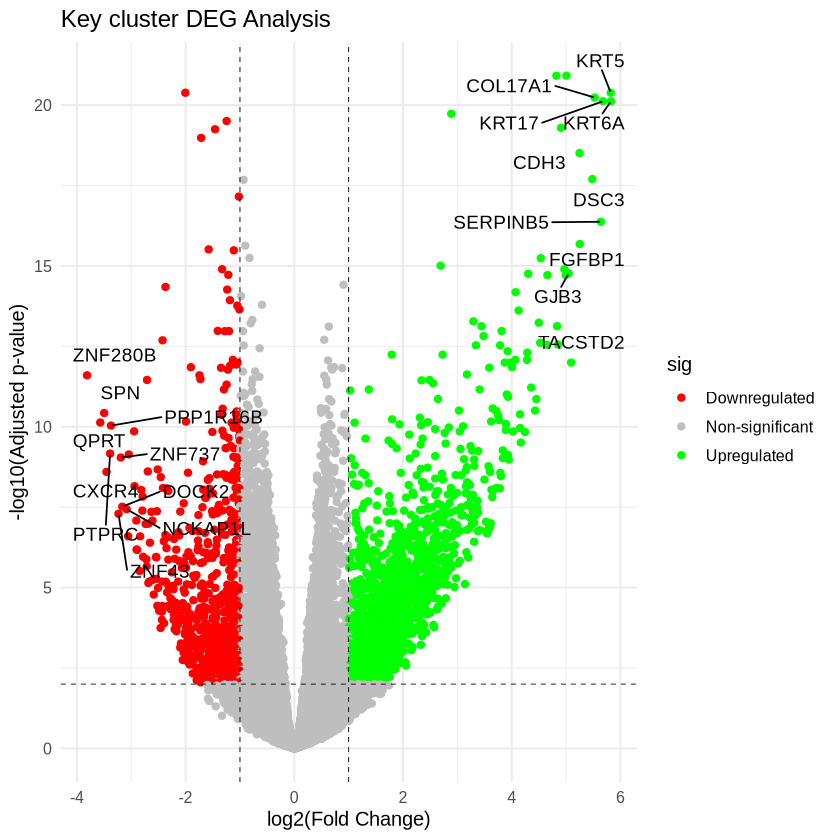

In [26]:
print(P)

In [43]:
ggsave(
  plot = P,
  filename = "/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Figs/keyCluster_deg_28122025_optuna.pdf",
  width = 8.27,
  height = 11.69,
  units = "in",
  dpi = 600,
  device = cairo_pdf
)


Warning message:
“Removed 16269 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


In [28]:

# Identify top 10 upregulated and downregulated genes
top_up <- df %>%
  filter(sig == "Upregulated") %>%
  head(100)

top_down <- df %>%
  filter(sig == "Downregulated") %>%
  head(100)

top_genes <- bind_rows(top_up, top_down)
top_gene_list <- rownames(top_genes)

In [44]:
writeLines(top_gene_list, con = '/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Data/depMap_keyCluster_topDEG_optuna.txt')

In [45]:
write.csv(metadata_df, '/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Data/egfr_erlotinib_fullRes_optuna.csv', row.names=TRUE)

#### Benefit score DEG analysis

In [31]:
str(fit2)

Formal class 'MArrayLM' [package "limma"] with 1 slot
  ..@ .Data:List of 23
  .. ..$ : num [1:16289, 1:3] 0.557 1.496 -0.678 1.273 5.607 ...
  .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. ..$ : chr [1:16289] "A1BG" "A1BG.AS1" "A2M" "A4GALT" ...
  .. .. .. ..$ : chr [1:3] "(Intercept)" "keyClusterkey_cluster" "Benefit_Score_cathigh_score"
  .. ..$ : int 3
  .. ..$ : int [1:3] 0 1 2
  .. ..$ :List of 5
  .. .. ..$ qr   : num [1:686, 1:3] -26.1916 0.0382 0.0382 0.0382 0.0382 ...
  .. .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. .. ..$ : chr [1:686] "22RV1" "2313287" "253J" "253JBV" ...
  .. .. .. .. ..$ : chr [1:3] "(Intercept)" "keyClusterkey_cluster" "Benefit_Score_cathigh_score"
  .. .. .. ..- attr(*, "assign")= int [1:3] 0 1 2
  .. .. .. ..- attr(*, "contrasts")=List of 2
  .. .. .. .. ..$ keyCluster       : chr "contr.treatment"
  .. .. .. .. ..$ Benefit_Score_cat: chr "contr.treatment"
  .. .. ..$ qraux: num [1:3] 1.04 1.01 1.04
  .. .. ..$ pivot: int [1:3] 1 2 3
  .. .

In [32]:
res <- topTable(fit2, coef = "Benefit_Score_cathigh_score", number = Inf)
res %>%
  filter(abs(logFC) > 1 & adj.P.Val < 0.05) %>%
  dim()

head(res)

[1] 938   6

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SLC4A2,-0.7545892,7.2230569,-12.31535,1.251082e-31,2.037887e-27,60.83241
ZCCHC24,-1.7015602,3.1702278,-11.63995,1.053423e-28,7.365206e-25,54.24360
SLC15A2,1.8095449,0.6344019,11.61410,1.356475e-28,7.365206e-25,53.99633
PPP4R3A,0.4713194,6.2819375,11.45253,6.535546e-28,2.661438e-24,52.45876
PLOD3,-1.0380196,6.4178663,-11.04999,3.080775e-26,1.003655e-22,48.69183
C1orf74,0.7908095,3.2233668,10.91782,1.069488e-25,2.903483e-22,47.47539


In [33]:
df <- res %>%
  filter(!is.na(logFC), !is.na(adj.P.Val))
df$gene <- rownames(df)
# Create a column for significance
df <- df %>%
  mutate(
    sig = case_when(
      adj.P.Val < 0.01 & logFC > 1 ~ "Upregulated",
      adj.P.Val < 0.01 & logFC < -1 ~ "Downregulated",
      TRUE ~ "Non-significant"
    )
  )

# Identify top 10 upregulated and downregulated genes
top_up <- df %>%
  filter(sig == "Upregulated") %>%
  top_n(10, logFC)

top_down <- df %>%
  filter(sig == "Downregulated") %>%
  top_n(-10, logFC)

top_genes <- bind_rows(top_up, top_down)
top_gene_list <- rownames(top_genes)

In [34]:
df['EGFR',]

,logFC,AveExpr,t,P.Value,adj.P.Val,B,gene,sig
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
EGFR,-1.257353,5.936978,-4.494723,8.175805e-06,4.972953e-05,3.091591,EGFR,Downregulated


In [35]:
df$gene <- rownames(df)
df$top_gene <- ifelse(df$gene %in% top_gene_list, df$gene, NA)

In [36]:
P <- ggplot(df, aes(x = logFC, y = -log10(adj.P.Val), color = sig)) +
  geom_point() +
  geom_vline(xintercept = c(-1, 1), linetype = "dashed", color = "black", linewidth = 0.25) +
  geom_hline(yintercept = -log10(0.01), linetype = "dashed", color = "black", linewidth = 0.25) +
  geom_text_repel(
    data = df,
    aes(x = logFC, y = -log10(adj.P.Val), label = top_gene),
    size = 4,
    color = "black",
    box.padding = 0.5,
    max.overlaps = 50
  ) +
  scale_color_manual(
    values = c(
      "Downregulated" = "red",
      "Upregulated" = "green",
      "Non-significant" = "grey"
    ),
    na.value = "grey"  # ensures NA gets grey color
  ) +
  labs(
    title = "Benefit score DEG Analysis",
    x = "log2(Fold Change)",
    y = "-log10(Adjusted p-value)"
  ) +
  theme_minimal(base_size = 12) 

In [46]:
ggsave(
  plot = P,
  filename = "/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Figs/benefitScore_depMap_deg_28122025_optuna.pdf",
  width = 8.27,
  height = 11.69,
  units = "in",
  dpi = 600,
  device = cairo_pdf
)


Warning message:
“Removed 16269 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


Warning message:
“Removed 16269 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


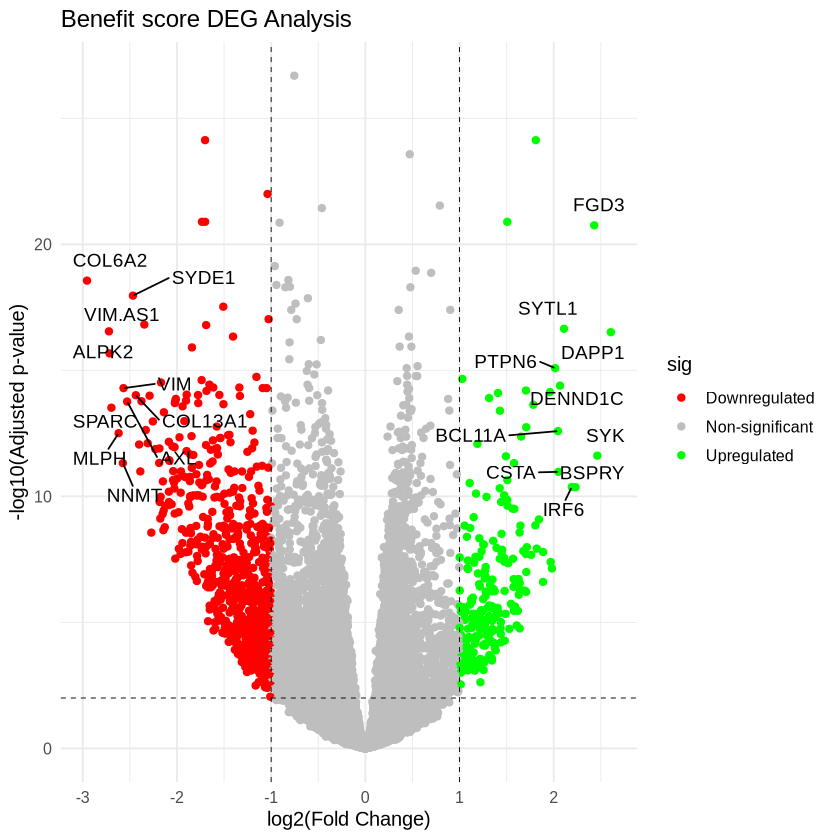

In [38]:
print(P)

In [47]:
# Identify top 10 upregulated and downregulated genes
top_up <- df %>%
  filter(sig == "Upregulated") %>%
  head(100)

top_down <- df %>%
  filter(sig == "Downregulated") %>%
  head(100)

top_genes <- bind_rows(top_up, top_down)
top_gene_list <- rownames(top_genes)

writeLines(top_gene_list, con = '/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Data/depMap_benefitScore_topDEG_28122025_optuna.txt')


In [48]:
write.csv(res, file = '/home/sreeramp/cancer_dependency_project/nilabja/Approach3_Latent_factor/git_repo/Data/depMap_benefitscore_deg_28122025_optuna.csv')